Purpose of this notebook is to setup a simple VAE that can learn poses of cubes.

@yvan june 9 2018

Setup

In [35]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
from torch.autograd import Variable
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms import transforms

In [2]:
# constants
NEPOCHS = 100
BATCH_SIZE = 64
SEED = 1337
IMG_DIM = 64
ncpus = !nproc
NCPUS = int(ncpus[0])
IMG_PATH = '/home/yvan/data_load/imgs_jpg_clpr_128/'

In [12]:
torch.cuda.is_available(), torch.__version__, torch.cuda.device_count(), torch.cuda.device(0)

(True, '0.4.0', 2, <torch.cuda.device at 0x7ff2d1de7cf8>)

In [4]:
t = transforms.Compose([transforms.ToTensor()])
cube_dataset = ImageFolder(IMG_PATH, transform=t)
cube_loader = data.DataLoader(dataset=cube_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NCPUS)

Create a simple VAE model.

In [5]:
# thanks to https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/Variational_autoencoder.py
# for his implementation of a simple VAE
class Vae(nn.Module):
    def __init__(self):
        super(Vae,self).__init__()
        # encoder dense layers
        self.dense1 = nn.Linear(3*IMG_DIM*IMG_DIM, int(IMG_DIM*IMG_DIM/50))
        # two output vectors, one for mu, and one for log variance.
        self.dense11 = nn.Linear(int(IMG_DIM*IMG_DIM/50), 25)
        self.dense12 = nn.Linear(int(IMG_DIM*IMG_DIM/50), 25)
        # decoder dense layers
        self.dense3 = nn.Linear(25, int(IMG_DIM*IMG_DIM/50))
        self.dense4 = nn.Linear(int(IMG_DIM*IMG_DIM/50), IMG_DIM*IMG_DIM*3)
        
    def encode(self, x):
        x = F.relu(self.dense1(x))
        return self.dense11(x), self.dense12(x)
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            epsilon = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            epsilon = torch.FloatTensor(std.size()).normal_()
        epsilon = Variable(epsilon)
        return epsilon.mul(std).add(mu)
    
    def decode(self, x):
        x = F.relu(self.dense3(x))
        return F.sigmoid(self.dense4(x))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_func(reconstructed, original, mu, logvar):
    mse = nn.MSELoss(size_average=False)(reconstructed, original)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kld

In [6]:
model = Vae()
if torch.cuda.is_available():
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NEPOCHS):
    model.train()
    for i, batch in enumerate(cube_loader):
        # get and flatten img, move to gpu
        img, _ = batch
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        # run our vae
        reconstructed_batch, mu, logvar = model(img)
        loss = loss_func(reconstructed_batch, img, mu, logvar)
        # backprop the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch{epoch}:{loss.item()}')

epoch0:19872.166015625


/home/yvan/anaconda3/envs/cLPR/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch1:19017.341796875
epoch2:17361.87890625
epoch3:16760.869140625
epoch4:15440.2265625
epoch5:14630.119140625
epoch6:14549.39453125
epoch7:13672.3798828125
epoch8:13770.0546875
epoch9:13307.341796875
epoch10:13438.7783203125
epoch11:13356.1259765625
epoch12:13339.17578125
epoch13:13320.2470703125
epoch14:12995.9296875
epoch15:13037.9951171875
epoch16:13066.3984375
epoch17:13098.720703125
epoch18:13159.02734375
epoch19:12850.208984375
epoch20:12901.28515625
epoch21:13225.48046875
epoch22:12502.123046875
epoch23:13139.8984375
epoch24:12731.8623046875
epoch25:12275.2373046875
epoch26:12868.48046875
epoch27:12112.962890625
epoch28:12002.533203125
epoch29:12261.39453125
epoch30:12542.9130859375
epoch31:12635.7060546875
epoch32:12012.083984375
epoch33:11978.9501953125
epoch34:11970.4130859375
epoch35:12113.521484375
epoch36:11907.875
epoch37:11825.564453125
epoch38:11820.58984375
epoch39:11899.7490234375
epoch40:11694.0341796875
epoch41:11908.6484375
epoch42:11446.439453125
epoch43:11616.6

In [18]:
model.eval()
sample = torch.randn(64, 25).cuda()
sample = model.decode(sample).cpu()

In [32]:
firstimg = sample.view(64, 3, 64, 64)

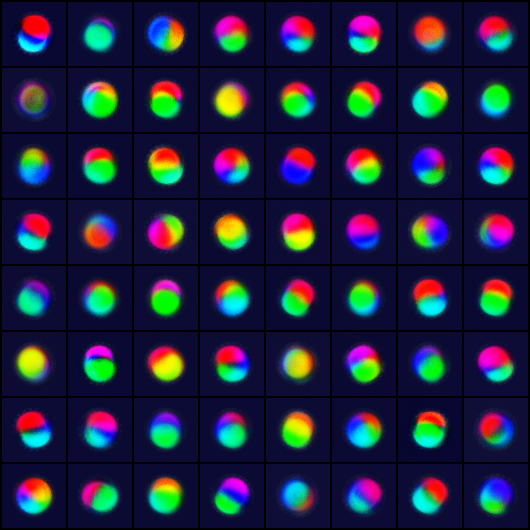

In [46]:
grid = make_grid(firstimg)
grid = transforms.Compose([transforms.ToPILImage()])(grid)
grid

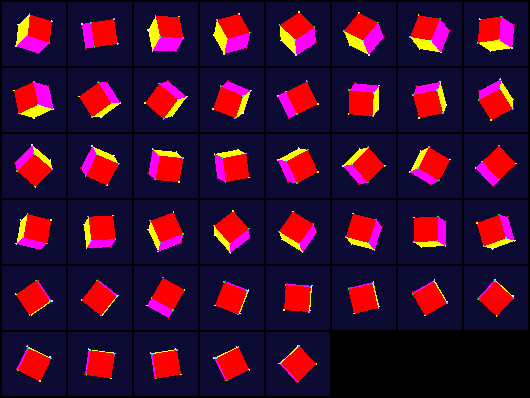

In [49]:
imggrid = make_grid(batch[0])
imggrid = transforms.Compose([transforms.ToPILImage()])(imggrid)
imggrid